In [1]:
# Wholesale Customers Segmentation
# Segment wholesale customers into groups based on annual spending across product categories.

# 1. Install and import libraries
!pip install numpy pandas matplotlib seaborn scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

In [3]:
# 2. Load dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
df = pd.read_csv(url)

In [14]:
# Count of NaN values per column
nan_counts = df.isna().sum()

# Count of duplicate rows
duplicate_count = df.duplicated().sum()

print("NaN Values per Column:\n", nan_counts)
print("\nTotal Duplicate Rows:", duplicate_count)

NaN Values per Column:
 Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

Total Duplicate Rows: 0


   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen  

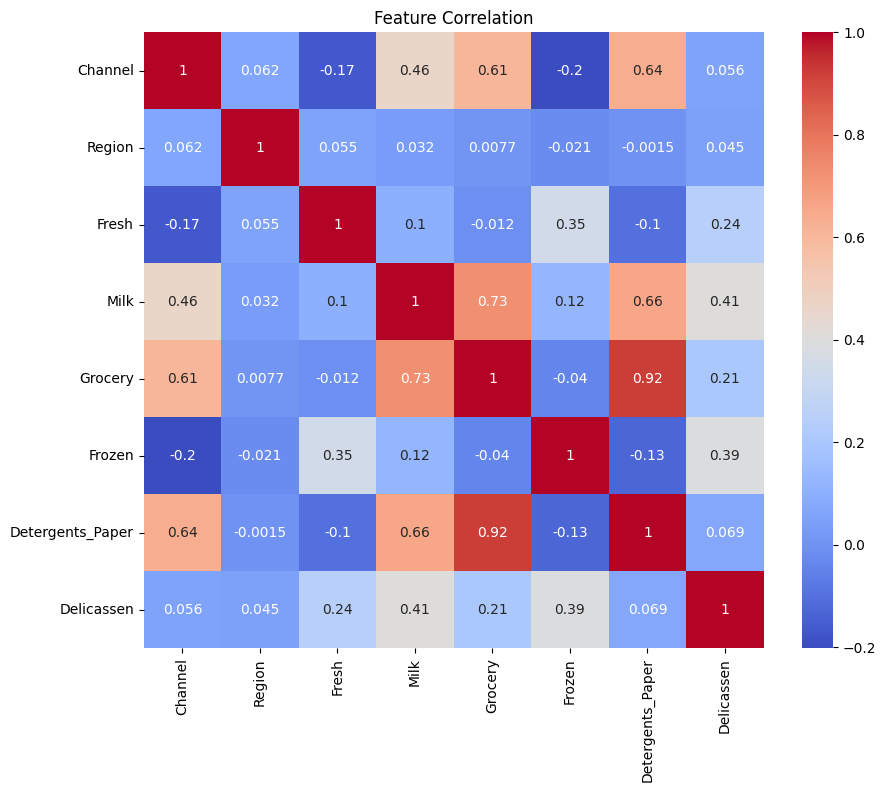

In [4]:
# 3. Exploratory Data Analysis
print(df.head())
print(df.info())
print(df.describe())

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()


In [7]:
# 4. Preprocessing
# We focus on numeric spending features for clustering
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
X = df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
# 5. Clustering methods
# 5.1 K-Means clustering
k = 3  # number of clusters (can vary)
kmeans = KMeans(n_clusters=k, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

In [23]:
# 5.2 Hierarchical clustering (Agglomerative)
hier = AgglomerativeClustering(n_clusters=k)
labels_hc = hier.fit_predict(X_scaled)


In [24]:
# 6. Evaluation of clustering
methods = ['KMeans', 'Hierarchical']
labels_list = [labels_km, labels_hc]
results = []

for name, labels in zip(methods, labels_list):
    n_clusters = len(set(labels))
    if n_clusters > 1:
        sil = silhouette_score(X_scaled, labels)
    else:
        sil = np.nan
    results.append({'Method': name, 'Clusters': n_clusters, 'Silhouette': sil})

results_df = pd.DataFrame(results)
print(results_df)


         Method  Clusters  Silhouette
0        KMeans         3    0.458263
1  Hierarchical         3    0.264609


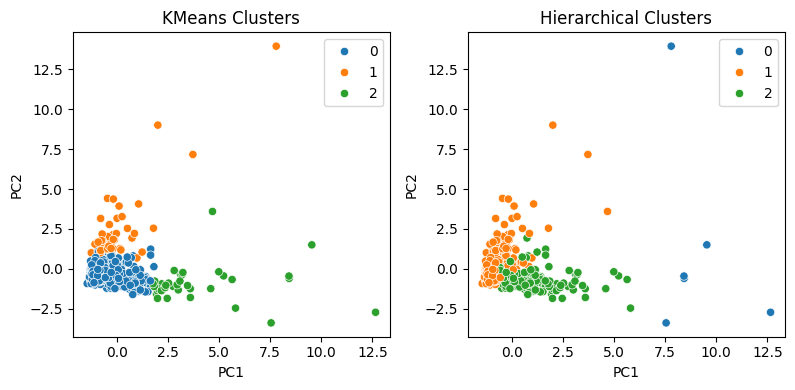

In [25]:
# 7. Visualization via PCA (2D)
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
plt.figure(figsize=(12,4))
for i, (name, labels) in enumerate(zip(methods, labels_list), 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=components[:,0], y=components[:,1], hue=labels, palette='tab10', legend='full')
    plt.title(f'{name} Clusters')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# 8. Conclusions
# Compare metrics and visualizations to choose the best segmentation method. Adjust k or DBSCAN parameters as needed.


    k      Inertia  Silhouette
0   2  2266.955267    0.399828
1   3  1644.059851    0.458263
2   4  1326.674608    0.349391
3   5  1070.255200    0.368901
4   6   989.332642    0.276246
5   7   856.707023    0.276678
6   8   791.828076    0.323665
7   9   710.194339    0.294537
8  10   668.222505    0.228769
Best k by Silhouette Score: 3


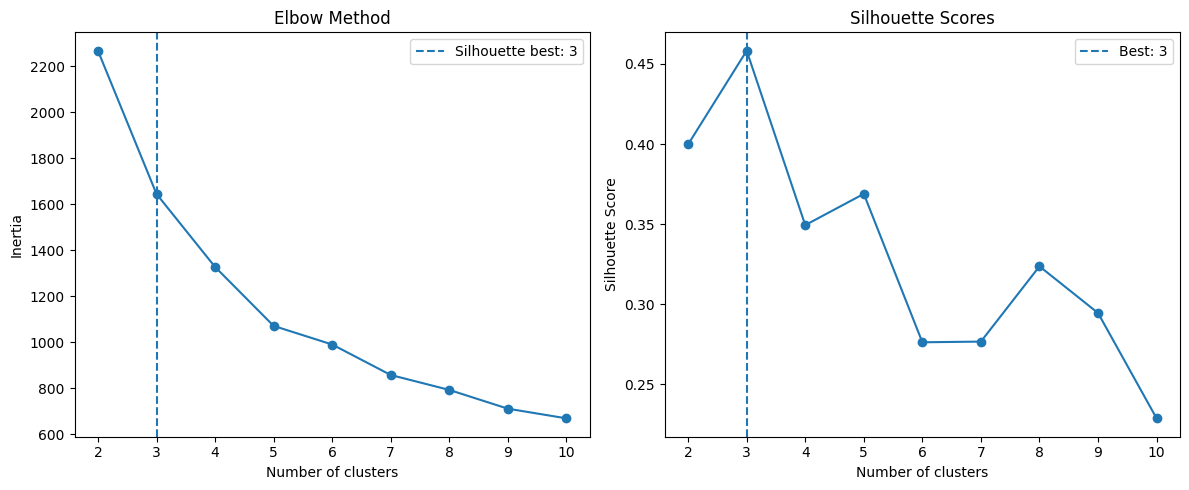

In [18]:
# 4. Evaluate clustering for different k
range_n_clusters = list(range(2, 11))  # try k from 2 to 10
inertias = []
silhouette_scores = []

for k in range_n_clusters:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# 5. Summarize results and determine best k
results_df = pd.DataFrame({
    'k': range_n_clusters,
    'Inertia': inertias,
    'Silhouette': silhouette_scores
})
print(results_df)

# Identify optimal k by silhouette
best_k_silhouette = int(results_df.loc[results_df['Silhouette'].idxmax(), 'k'])
print(f"Best k by Silhouette Score: {best_k_silhouette}")

# 6. Plot metrics with best k annotated
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results_df['k'], results_df['Inertia'], marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.axvline(best_k_silhouette, linestyle='--', label=f'Silhouette best: {best_k_silhouette}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results_df['k'], results_df['Silhouette'], marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.axvline(best_k_silhouette, linestyle='--', label=f'Best: {best_k_silhouette}')
plt.legend()

plt.tight_layout()
plt.show()

# 7. Interpretation
# Use the Elbow method and Silhouette score to choose k, e.g., k = best_k_silhouette
